In [ ]:
# Install MALLET 2.0.8RC3 from the official site
!wget http://mallet.cs.umass.edu/dist/mallet-2.0.8RC3.zip -O ~/mallet-2.0.8RC3.zip

# Unzip MALLET
!unzip ~/mallet-2.0.8RC3.zip -d ~/
!rm ~/mallet-2.0.8RC3.zip

# Rename the folder for convenience
!mv ~/mallet-2.0.8RC3 ~/mallet-2.0.8

# Define the path to the "mallet" binary
import os
mallet_dir = os.path.expanduser('~/mallet-2.0.8')
path_to_mallet = os.path.join(mallet_dir, 'bin', 'mallet')
print(f"Path to MALLET: {path_to_mallet}")

# Optionally check Java version
!java -version

In [ ]:
!pip install little_mallet_wrapper openpyxl

In [2]:
# -*- coding: utf-8 -*-
"""
Integrated script for MALLET-based topic modeling with per-file Fisher’s Exact
filtering and stopword exclusion. UTF-8 friendly.
Outputs:
  - Topic keys
  - Per-document topic distributions
  - Excel workbook with:
      • Topic tokens
      • Token counts per document
      • Topic probabilities per document
  - Separate Excel workbook with top-document titles per topic

Graphical output (heatmap & boxplots) is disabled in this pipeline.
See plotting_helpers.py for on-demand plotting.
"""


import os
import csv
import time
from pathlib import Path
from collections import Counter

import pandas as pd
from scipy.stats import fisher_exact
import little_mallet_wrapper
from openpyxl import Workbook
from openpyxl.utils.dataframe import dataframe_to_rows
import pickle

# Change this path to point to the local MALLET binary in the current directory.
# For example, place the mallet-2.0.8 folder in the same directory as this script.
# Then use os.path.join(...) relative to the current working directory (codespace).
mallet_dir = os.path.expanduser('~/mallet-2.0.8')
path_to_mallet = os.path.join(mallet_dir, 'bin', 'mallet')

# These will be set by main() and picked up by plotting_helpers.py
OUTPUT_DIR = None
NUM_TOPICS = None

def tokenize_file(filepath):
    """Load a UTF-8 text file and split on whitespace (preserves accents)."""
    with open(filepath, "r", encoding="utf-8") as f:
        return f.read().split()

def list_txt_files(directory):
    """Return a sorted list of all .txt filenames in a directory."""
    return sorted(fn for fn in os.listdir(directory) if fn.endswith(".txt"))

def list_csv_files(directory):
    """
    Recursively find all .csv files under a directory, skipping
    any .ipynb_checkpoints folders.
    """
    csv_paths = []
    for root, dirs, files in os.walk(directory):
        if ".ipynb_checkpoints" in dirs:
            dirs.remove(".ipynb_checkpoints")
        for fn in files:
            if fn.lower().endswith(".csv"):
                csv_paths.append(os.path.join(root, fn))
    return csv_paths

def choose_directory(prompt):
    """
    Display a numbered list of immediate subdirectories (plus current dir)
    and return the full path selected by the user.
    """
    cwd = os.getcwd()
    base = Path(cwd).name
    subdirs = [
        d for d in os.listdir(cwd)
        if os.path.isdir(os.path.join(cwd, d)) and d != ".ipynb_checkpoints"
    ]
    options = [(os.path.join(cwd, d), f"{base}/{d}") for d in subdirs]
    options.append((cwd, base))

    print(prompt)
    for i, (_, label) in enumerate(options, start=1):
        print(f"{i}. {label}")

    while True:
        try:
            choice = int(input("Enter number: ").strip())
            if 1 <= choice <= len(options):
                return options[choice - 1][0]
        except ValueError:
            pass
        print("Invalid choice, please try again.")

def choose_files(filenames):
    """
    Let user pick one or more filenames by:
      - indices ("2" or "1,3")
      - index ranges ("1-4")
      - prefix matching ("report")
      - or the keyword "all" to select every file.
    Returns a sorted, unique list of chosen filenames.
    """
    print("Available files:")
    for i, fn in enumerate(filenames, start=1):
        print(f"{i}. {fn}")
    choice = input("Select files (indices, ranges, prefix, or 'all'): ").strip().lower()

    if choice == "all":
        return filenames.copy()

    selected = []
    for part in choice.split(","):
        part = part.strip()
        if part == "all":
            return filenames.copy()
        if "-" in part:
            a, b = map(int, part.split("-"))
            selected.extend(filenames[a - 1:b])
        elif part.isdigit():
            selected.append(filenames[int(part) - 1])
        else:
            selected.extend(fn for fn in filenames if fn.startswith(part))
    return sorted(set(selected))

def choose_csv_file(csv_paths):
    """
    Prompt the user to select one CSV from a list of paths.
    Returns the chosen filepath.
    """
    cwd = os.getcwd()
    base = Path(cwd).name
    print("Select your stopwords CSV:")
    for i, full in enumerate(csv_paths, start=1):
        rel = os.path.relpath(full, cwd)
        print(f"{i}. {base}/{rel}")

    while True:
        try:
            choice = int(input("Enter number: ").strip())
            if 1 <= choice <= len(csv_paths):
                return csv_paths[choice - 1]
        except ValueError:
            pass
        print("Invalid choice, please try again.")

def read_stopwords(filepath):
    """Load stopwords from a CSV, splitting on commas and trimming whitespace."""
    sw = []
    with open(filepath, "r", encoding="utf-8") as f:
        for row in csv.reader(f):
            for cell in row:
                sw.extend(cell.split(","))
    return [w.strip() for w in sw if w.strip()]

def get_fishers(word, freq_dict, rate_dict, alternative="greater"):
    """
    Perform Fisher’s Exact Test on one token:
        [[observed, total-observed],
         [expected, total-expected]]
    Returns the p-value.
    """
    observed = freq_dict.get(word, 0)
    total = sum(freq_dict.values())
    expected = round(rate_dict.get(word, 0) * total)
    table = [
        [observed, total - observed],
        [expected, total - expected]
    ]
    _, pval = fisher_exact(table, alternative=alternative)
    return pval

def calculate_rate_dictionary(rate_files, rate_dir):
    """
    Build a background rate dictionary from reference documents.
    Returns a mapping { token: relative_frequency }.
    """
    counter = Counter()
    total_tokens = 0
    for fn in rate_files:
        tokens = tokenize_file(os.path.join(rate_dir, fn))
        counter.update(tokens)
        total_tokens += len(tokens)
    return {tok: cnt / total_tokens for tok, cnt in counter.items()}

def prepare_training_data(files, directory, stopwords, rate_dict, alpha):
    """
    For each file:
      1. Tokenize and count every token.
      2. Exclude stopwords and tokens with Fisher p-value ≥ alpha.
      3. Collect filtered document text and raw token counts.
    Prints per-file progress with elapsed time.
    Returns:
      - docs: list of filtered document strings for MALLET input
      - distributions: list of Counter objects of raw token counts
    """
    docs = []
    distributions = []
    total = len(files)
    overall_start = time.time()

    for idx, fn in enumerate(files, start=1):
        file_start = time.time()
        print(f"[{idx}/{total}] ⏳ Processing '{fn}'... ")

        path = os.path.join(directory, fn)
        tokens = tokenize_file(path)
        freq = Counter(tokens)

        filtered = [
            w for w in tokens
            if w not in stopwords and get_fishers(w, freq, rate_dict) < alpha
        ]
        docs.append(" ".join(filtered))
        distributions.append(freq)

        elapsed = time.time() - file_start
        kept = len(filtered)
        before = len(tokens)
        pct = (kept / before * 100) if before else 0
        print(f"done in {elapsed:.1f}s – kept {kept}/{before} tokens ({pct:.1f}%).")

    total_elapsed = time.time() - overall_start
    print(f"[Done] Prepared {total} documents in {total_elapsed:.1f}s.\n")
    return docs, distributions

def train_topic_model(training_docs, num_topics, output_dir):
    """
    Train a MALLET model via little_mallet_wrapper
    Returns:
      - topics: list of token lists (topic keys)
      - doc_topics: list of probability lists (per-document topic distributions)
    """
    Path(output_dir).mkdir(parents=True, exist_ok=True)

    # Make sure MALLET is installed and that path_to_mallet points to the local file in the codespace.
    little_mallet_wrapper.quick_train_topic_model(
        path_to_mallet,
        output_dir,
        num_topics,
        training_docs
    )

    key_file = os.path.join(output_dir, f"mallet.topic_keys.{num_topics}")
    topics = little_mallet_wrapper.load_topic_keys(key_file)

    dist_file = os.path.join(output_dir, f"mallet.topic_distributions.{num_topics}")
    doc_topics = little_mallet_wrapper.load_topic_distributions(dist_file)

    return topics, doc_topics

def save_results_to_excel(excel_path, topics, token_distributions, doc_topics, files):
    """
    Create an Excel workbook with:
      1) 'Topics' sheet: one row per topic (Topic#, top tokens...)
      2) One sheet per document: raw token counts (removing '_stemmed' suffix)
      3) 'DocTopicDist' sheet: topic probabilities per document
    """
    wb = Workbook()
    ws0 = wb.active
    ws0.title = "Topics"
    for idx, topic in enumerate(topics):
        ws0.append([f"Topic {idx}"] + topic)

    for fn, dist in zip(files, token_distributions):
        sheet_name = Path(fn).stem.replace("_stemmed", "")
        sheet = wb.create_sheet(title=sheet_name)
        df = pd.DataFrame.from_dict(dist, orient="index", columns=["count"])
        for row in dataframe_to_rows(df, index=True, header=True):
            sheet.append(row)

    ws3 = wb.create_sheet(title="DocTopicDist")
    header = ["Document"] + [f"Topic{t}" for t in range(len(topics))]
    ws3.append(header)
    for fn, probs in zip(files, doc_topics):
        doc_name = Path(fn).stem.replace("_stemmed", "")
        ws3.append([doc_name] + [round(p, 4) for p in probs])

    wb.save(excel_path)

def save_top_titles_excel(xlsx_path, topics, training_docs, doc_topics, doc_titles, n_docs):
    """
    Save the top n_docs document titles per topic into an Excel file,
    one sheet per topic named 'Topic{#}', and remove the default blank sheet.
    """
    wb = Workbook()
    default_sheet = wb.active
    wb.remove(default_sheet)

    for t_idx in range(len(topics)):
        ws = wb.create_sheet(title=f"Topic{t_idx}")
        ws.append(["Probability", "Document Title"])
        for prob, doc in little_mallet_wrapper.get_top_docs(
            training_docs, doc_topics, t_idx, n=n_docs
        ):
            title = doc_titles.get(doc, Path(doc).stem)
            ws.append([round(prob, 4), title])

    wb.save(xlsx_path)

def input_float(prompt, min_val=None, max_val=None, default=None):
    """Prompt until the user enters a valid float (and optionally within range)."""
    while True:
        # Add default value to prompt if it exists
        if default is not None:
            prompt_with_default = f"{prompt} [default: {default}] "
        else:
            prompt_with_default = prompt
        
        resp = input(prompt_with_default).strip()
        
        # Return default if response is empty
        if not resp and default is not None:
            return default
            
        try:
            val = float(resp)
            if min_val is not None and val < min_val:
                print(f"Value must be at least {min_val}.")
                continue
            if max_val is not None and val > max_val:
                print(f"Value must be at most {max_val}.")
                continue
            return val
        except ValueError:
            print("Invalid input, please enter a valid number.")

def input_int(prompt, min_val=None, max_val=None):
    """Prompt until the user enters a valid integer (and optionally within range)."""
    while True:
        resp = input(prompt).strip()
        try:
            val = int(resp)
            if min_val is not None and val < min_val:
                print(f"Value must be at least {min_val}.")
                continue
            if max_val is not None and val > max_val:
                print(f"Value must be at most {max_val}.")
                continue
            return val
        except ValueError:
            print("Invalid input, please enter a valid integer.")

def main():
    global OUTPUT_DIR, NUM_TOPICS

    # Prompt user: reuse preprocessed data or run full pipeline
    reuse = input("Reuse preprocessed data? (y/n): ").strip().lower()
    if reuse == 'y':
        # Enumerate possible folders containing preprocessed data
        cwd = os.getcwd()
        # List all subdirectories in cwd that contain 'preprocessed_docs.pkl'
        candidates = []
        for d in os.listdir(cwd):
            full_path = os.path.join(cwd, d)
            if os.path.isdir(full_path):
                pkl_path = os.path.join(full_path, "preprocessed_docs.pkl")
                if os.path.exists(pkl_path):
                    candidates.append(d)
        if not candidates:
            print("No folders with preprocessed data found in this directory.")
            return
        print("Select a folder containing preprocessed data:")
        for i, d in enumerate(candidates, start=1):
            print(f"{i}. {d}")
        while True:
            try:
                choice = int(input("Enter number: ").strip())
                if 1 <= choice <= len(candidates):
                    pre_dir = candidates[choice - 1]
                    break
            except ValueError:
                pass
            print("Invalid choice, please try again.")
        OUTPUT_DIR = os.path.join(cwd, pre_dir)
        with open(os.path.join(OUTPUT_DIR, "preprocessed_docs.pkl"), "rb") as f:
            training_docs, token_distributions, target_files = pickle.load(f)
        print(f"Loaded preprocessed data from {OUTPUT_DIR}.")
    else:
        # 1) Choose and load stopwords CSV
        stop_csv = choose_csv_file(list_csv_files(os.getcwd()))
        stopwords = read_stopwords(stop_csv)

        # 2) Build background rate dictionary
        rate_dir = choose_directory("Select reference text directory:")
        rate_files = choose_files(list_txt_files(rate_dir))
        rate_dict = calculate_rate_dictionary(rate_files, rate_dir)

        # 3) Select target files
        target_dir = choose_directory("Select target text directory:")
        target_files = choose_files(list_txt_files(target_dir))

        # 4) Output folder
        while True:
            out_sub = input("Enter name for output folder: ").strip()
            if out_sub:
                break
            print("Output folder name cannot be empty.")
        OUTPUT_DIR = os.path.join(os.getcwd(), out_sub)
        Path(OUTPUT_DIR).mkdir(parents=True, exist_ok=True)

        # 5) Fisher’s Exact threshold
        alpha = input_float(
            "Enter Fisher’s Exact alpha threshold:",
            min_val=0.0, max_val=1.0, default=0.05
        )

        # 6) Prepare filtered training data
        training_docs, token_distributions = prepare_training_data(
            target_files, target_dir, stopwords, rate_dict, alpha
        )

        # 7) Save preprocessed data for reuse
        with open(os.path.join(OUTPUT_DIR, "preprocessed_docs.pkl"), "wb") as f:
            pickle.dump((training_docs, token_distributions, target_files), f)
        print(f"Preprocessed data saved to {OUTPUT_DIR}.")

    # Prompt for one or more numbers of topics
    topic_str = input("Enter number(s) of topics to generate (e.g., 10, 20-23, 30): ").strip()
    topic_nums = []
    for part in topic_str.split(','):
        part = part.strip()
        if '-' in part:
            try:
                start, end = map(int, part.split('-'))
                if start <= end:
                    topic_nums.extend(range(start, end + 1))
                else:
                    # Handle case where user enters range in reverse order
                    topic_nums.extend(range(end, start + 1))
            except ValueError:
                print(f"Ignoring invalid range: '{part}'")
        elif part.isdigit():
            topic_nums.append(int(part))
            
    topic_nums = sorted(list(set(topic_nums))) # Remove duplicates and sort

    if not topic_nums:
        print("No valid topic numbers entered. Exiting.")
        return

    # Prompt for number of top documents per topic
    n_top_docs = input_int("Enter number of top documents per topic: ", min_val=1)
    for num_topics in topic_nums:
        print(f"\n--- Training topic model with {num_topics} topics ---")
        NUM_TOPICS = num_topics
        run_dir = os.path.join(OUTPUT_DIR, f"topics_{num_topics}")
        Path(run_dir).mkdir(parents=True, exist_ok=True)
        topics, doc_topics = train_topic_model(training_docs, NUM_TOPICS, run_dir)
        fn_list_path = os.path.join(run_dir, "input_filenames.txt")
        with open(fn_list_path, "w", encoding="utf-8") as f:
            for fn in target_files:
                f.write(fn + "\n")
        excel_results = os.path.join(run_dir, "topic_model_results.xlsx")
        save_results_to_excel(excel_results, topics, token_distributions, doc_topics, target_files)
        doc_titles = {doc: Path(fn).stem for doc, fn in zip(training_docs, target_files)}
        top_titles_path = os.path.join(run_dir, "top_titles.xlsx")
        save_top_titles_excel(
            top_titles_path, topics, training_docs, doc_topics, doc_titles, n_top_docs
        )
        print(f"✅ Finished {num_topics} topics. Results in {run_dir}.")
    print("\nAll requested topic models completed!")
    print("To create heatmaps or boxplots, import and run plotting_helpers.generate_heatmap() or generate_boxplots().")

if __name__ == "__main__":
    main()

Select your stopwords CSV:
1. lemmatized/stop_words.csv
Select reference text directory:
1. lemmatized/concordances
2. lemmatized/Sept0325
3. lemmatized
Available files:
1. 0Théatre summary_corrected_stemmed.txt
2. Discours des raisons_corrected_stemmed.txt
3. Démonomanie I.1_corrected_stemmed.txt
4. Démonomanie I.2_corrected_stemmed.txt
5. Démonomanie I.3_corrected_stemmed.txt
6. Démonomanie I.4_corrected_stemmed.txt
7. Démonomanie I.5_corrected_stemmed.txt
8. Démonomanie I.6_corrected_stemmed.txt
9. Démonomanie I.7_corrected_stemmed.txt
10. Démonomanie II.1_corrected_stemmed.txt
11. Démonomanie II.2_corrected_stemmed.txt
12. Démonomanie II.3_corrected_stemmed.txt
13. Démonomanie II.4_corrected_stemmed.txt
14. Démonomanie II.5_corrected_stemmed.txt
15. Démonomanie II.6_corrected_stemmed.txt
16. Démonomanie II.7_corrected_stemmed.txt
17. Démonomanie II.8_corrected_stemmed.txt
18. Démonomanie III.1_corrected_stemmed.txt
19. Démonomanie III.2_corrected_stemmed.txt
20. Démonomanie III.3_c

Mallet LDA: 8 topics, 3 topic bits, 111 topic mask
Data loaded.
max tokens: 8044
total tokens: 84314
<10> LL/token: -6.55502
<20> LL/token: -6.25062
<30> LL/token: -6.15371
<40> LL/token: -6.10374

0	0.625	roy comt duc estat terr charl franc pay royaum part jour traict seigneur jean droit frer vill duch lettr couron 
1	0.625	magistrat loi puissanc princ don jug ordon senat command charg édict offic doit souverain offici particuli cas hommag tribun maiest 
2	0.625	sorci dieu diabl fort loi enfant peupl esprit mort sathan pein colleg femm natur malin crim harmon confess proport corp 
3	0.625	corp chos caus guerr ennemy sujet form eau vill natur pay ame bien romain arme mouv air fois feu paix 
4	0.625	dieu bien homm chos vertu mond princ mal divin ange ame fin ruin forc just volont entend lun vic aristot 
5	0.625	argent proc deni peu monnoy prix jour pay escus marc peupl fol estim grain veu advocat soleil fin vérit sous 
6	0.625	justic bien bon jug réform homm honneur mal gen temp injusti

Complete


/usr/local/python/3.12.1/lib/python3.12/site-packages/openpyxl/workbook/child.py:99: UserWarning: Title is more than 31 characters. Some applications may not be able to read the file
  warnings.warn("Title is more than 31 characters. Some applications may not be able to read the file")


✅ Finished 8 topics. Results in /workspaces/Jerusalimiec-Dissertation/Text/Sectionized/lemmatized/Sept0725/topics_8.

--- Training topic model with 9 topics ---
Importing data...
Complete
Training topic model...


Mallet LDA: 9 topics, 4 topic bits, 1111 topic mask
Data loaded.
max tokens: 8044
total tokens: 84314
<10> LL/token: -6.4735
<20> LL/token: -6.20006
<30> LL/token: -6.10961
<40> LL/token: -6.05791

0	0.55556	magistrat chos fort empir citoyen offic person charg offici vill plant rom bourgeois command mot tribun entend siecl appel cit 
1	0.55556	corp argent chos natur caus deni form fois fort monnoy prix animal mouv peu fin escus fol matier marc mond 
2	0.55556	roy jug enfant court gard conseil princ bon religion guerr paix homm mal sujet lettr ordon proc mer veu ennemy 
3	0.55556	roy duc comt franc royaum pay charl seigneur pap empereur droit hommag angleterr esclav don traict vill jean couron frer 
4	0.55556	dieu sorci diabl bien homm chos esprit ame sathan vertu mort crim malin ange confess aristot loi mal corp vic 
5	0.55556	mond peupl eau forc republ air nombr pay lun soleil raison harmon jour proport feu ruin froid element degr violenc 
6	0.55556	justic bien bon réform homm jug tem

Complete
✅ Finished 9 topics. Results in /workspaces/Jerusalimiec-Dissertation/Text/Sectionized/lemmatized/Sept0725/topics_9.

--- Training topic model with 10 topics ---
Importing data...
Complete
Training topic model...


Mallet LDA: 10 topics, 4 topic bits, 1111 topic mask
Data loaded.
max tokens: 8044
total tokens: 84314
<10> LL/token: -6.55955
<20> LL/token: -6.24523
<30> LL/token: -6.13827
<40> LL/token: -6.0661

0	0.5	republ senat don conseil charg estat nombr offici bien empir offic voit financ guerr gen ordinair jour grac celest cenfeur 
1	0.5	roy jug bon conseil court ordon moyen religion proc gard royaum veu gen temp mal justic assembl jour maison nom 
2	0.5	roy duc comt estat charl pay hommag franc droit traict esclav terr jean seigneur don frer duch lettr maistr philipp 
3	0.5	jug temp bon justic charg party gen offic proc colleg vray corp honneur animal air argent réform avaric laiss feu 
4	0.5	argent deni terr soleil fois eau monnoy escus prix pay lun peu mond marc natur fin domain peupl part fol 
5	0.5	bien justic homm chos bon réform mal caus ame vertu injustic mond corp dieu form princ public raison faveur natur 
6	0.5	loi peupl puissanc magistrat princ souverain jug command enfant ordon

Complete
✅ Finished 10 topics. Results in /workspaces/Jerusalimiec-Dissertation/Text/Sectionized/lemmatized/Sept0725/topics_10.

--- Training topic model with 11 topics ---
Importing data...
Complete
Training topic model...


Mallet LDA: 11 topics, 4 topic bits, 1111 topic mask
Data loaded.
max tokens: 8044
total tokens: 84314
<10> LL/token: -6.3925
<20> LL/token: -6.0713
<30> LL/token: -5.9633
<40> LL/token: -5.89063

0	0.45455	fort eau terr soleil natur animal air fois lun plant mond nombr feu hebrieu part element mot celest ciel diametr 
1	0.45455	roy comt duc estat charl hommag franc terr traict jean pay frer duch don droit lettr philipp seigneur vill jour 
2	0.45455	jug roy temp bon proc conseil party court mal justic mauvais ordon gard gen affair veu raison conscienc siecl regard 
3	0.45455	bien justic bon homm réform honneur injustic public mal charg sort vertu gen caus faveur vray vérit rend argent viv 
4	0.45455	chos corp ame bien caus homm form natur vertu mond fin naturel ange forc aristot lieu mouv volont matier entend 
5	0.45455	roy princ sujet empereur guerr royaum droit don romain franc empir pap pay seigneur paix vill ennemy arme souverainet souverain 
6	0.45455	republ estat bien seigneur vi

Complete
✅ Finished 11 topics. Results in /workspaces/Jerusalimiec-Dissertation/Text/Sectionized/lemmatized/Sept0725/topics_11.

--- Training topic model with 12 topics ---
Importing data...
Complete
Training topic model...


Mallet LDA: 12 topics, 4 topic bits, 1111 topic mask
Data loaded.
max tokens: 8044
total tokens: 84314
<10> LL/token: -6.31457
<20> LL/token: -6.03603
<30> LL/token: -5.9435
<40> LL/token: -5.90069

0	0.41667	roy duc comt franc charl pap pay royaum hommag angleterr terr traict don seigneur jean couron frer vill duch lettr 
1	0.41667	sorci dieu diabl esprit eau enfant sathan homm air esclav malin terr confess feu veu corp natur froid ange femm 
2	0.41667	bien justic bon homm réform mal honneur temp injustic public gen vertu caus sort charg faveur vray rend viv vérit 
3	0.41667	roy estat deput religion conseil royaum part tier franc nobless pay proport nobl jour assembl moyen paix deliber églis assemble 
4	0.41667	chos fort natur mond corp peupl caus fois soleil naturel form mouv animal republ fin lun nombr bourgeois matier jour 
5	0.41667	estat droit loi mar royaum femm maistr cas mort mer philipp don maison fill aisn enfant royn quant successeur adopt 
6	0.41667	bien ame chos corp vert

Complete
✅ Finished 12 topics. Results in /workspaces/Jerusalimiec-Dissertation/Text/Sectionized/lemmatized/Sept0725/topics_12.

--- Training topic model with 13 topics ---
Importing data...
Complete
Training topic model...


Mallet LDA: 13 topics, 4 topic bits, 1111 topic mask
Data loaded.
max tokens: 8044
total tokens: 84314
<10> LL/token: -6.31739
<20> LL/token: -6.06608
<30> LL/token: -5.96469
<40> LL/token: -5.87855

0	0.38462	bien homm dieu mal princ traict bon entend just ruin accord vic divin amour malad humain court outraig raison volont 
1	0.38462	loi peupl estat populair guerr puissanc enfant seigneur monarch esclav mort pay forc ancien aristocrat femm offici don cas romain 
2	0.38462	republ colleg chang vill tyran nombr famill estat corp mar ruin mond veu jour degr haut changemen puissanc neuf soleil 
3	0.38462	estat princ roy conseil senat peupl republ deput doit puissanc part souverain religion édict arrest tier moyen paix ordon gen 
4	0.38462	justic bien bon réform homm temp injustic honneur gen public caus party mal vertu sort charg vérit faveur rend argent 
5	0.38462	argent deni monnoy loi prix escus pein fol crim marc peu fort peupl grain ancien pay sous mer doit preuv 
6	0.38462	magistrat

Complete
✅ Finished 13 topics. Results in /workspaces/Jerusalimiec-Dissertation/Text/Sectionized/lemmatized/Sept0725/topics_13.

--- Training topic model with 14 topics ---
Importing data...
Complete
Training topic model...


Mallet LDA: 14 topics, 4 topic bits, 1111 topic mask
Data loaded.
max tokens: 8044
total tokens: 84314
<10> LL/token: -6.35456
<20> LL/token: -6.0463
<30> LL/token: -5.90735
<40> LL/token: -5.84216

0	0.35714	bien justic homm bon réform dieu mal vertu honneur injustic public sort vérit gen rend mond rich praticqu pauvr polic 
1	0.35714	estat peupl republ populair conseil senat puissanc aristocrat seigneur monarch bien chang tyran forc souverain princ mieux veu priv magistrat 
2	0.35714	caus faveur princ sainct court laiss demeur conscienc piet just outraig gaig sen fidel offens servyr crainct bretaign sénat jeun 
3	0.35714	roy princ sujet empereur guerr romain droit vill empir pap ennemy seigneur franc bien pay paix souverain arme allianc couron 
4	0.35714	mond republ colleg esclav vill corp lun citoyen hebrieu changemen celest ciel privileg voit empir cit maistr ruin vérit empereur 
5	0.35714	estat enfant republ deput don ancien tier domain franc famill royaum chef honneur maison fina

Complete
✅ Finished 14 topics. Results in /workspaces/Jerusalimiec-Dissertation/Text/Sectionized/lemmatized/Sept0725/topics_14.

--- Training topic model with 15 topics ---
Importing data...
Complete
Training topic model...


Mallet LDA: 15 topics, 4 topic bits, 1111 topic mask
Data loaded.
max tokens: 8044
total tokens: 84314
<10> LL/token: -6.2619
<20> LL/token: -5.97078
<30> LL/token: -5.87213
<40> LL/token: -5.80429

0	0.33333	roy princ royaum sujet loi souverain pap empereur estat droit peupl souverainet franc empir veu charl conseil couron angleterr ordon 
1	0.33333	magistrat jug puissanc offic senat charg command offici person tribun pein édict lettr cas peupl ordon consul marqu cour doit 
2	0.33333	moyen princip accord paris malad religion fin degr lyon flandr rent contrair savoir esprit beaucoup fer cuiur françois remed messir 
3	0.33333	conseil peupl eau terr air soleil proport pay feu fois harmon justic froid element lun homm diametr part raison nobl 
4	0.33333	chos corp ame natur form caus homm mond mouv animal fin fort naturel aristot matier entend fois plant lieu ange 
5	0.33333	argent deni monnoy fort pay escus prix marc peu fol domain ancien grain sous cinqu part financ forg poid veu 
6	0.33

Complete
✅ Finished 15 topics. Results in /workspaces/Jerusalimiec-Dissertation/Text/Sectionized/lemmatized/Sept0725/topics_15.

--- Training topic model with 16 topics ---
Importing data...
Complete
Training topic model...


Mallet LDA: 16 topics, 4 topic bits, 1111 topic mask
Data loaded.
max tokens: 8044
total tokens: 84314
<10> LL/token: -6.26266
<20> LL/token: -5.96199
<30> LL/token: -5.85068
<40> LL/token: -5.7798

0	0.3125	sorci dieu diabl sathan confess moyen financ malad preuv charg impost vérit mot accus mour parol diabol domain particuli histoir 
1	0.3125	mort conseil enfant senat loi empir doit crim puissanc pein cas ancien mer fill priv senateur adopt mour droit faisoit 
2	0.3125	roy duc comt estat pap charl hommag franc pay traict terr droit jean seigneur duch don lettr empir philipp baill 
3	0.3125	justic bien bon réform jug homm injustic honneur public mal charg party gen vérit rend raison sainct praticqu viv court 
4	0.3125	chos corp natur ame eau form mouv animal air fois caus mond plant naturel terr homm matier fort princip element 
5	0.3125	republ estat sujet princ peupl seigneur vill populair romain souverain souverainet aristocrat droit monarch empereur puissanc citoyen veu chang ennem

Complete
✅ Finished 16 topics. Results in /workspaces/Jerusalimiec-Dissertation/Text/Sectionized/lemmatized/Sept0725/topics_16.

All requested topic models completed!
To create heatmaps or boxplots, import and run plotting_helpers.generate_heatmap() or generate_boxplots().


Searching for topic model run directories...
Please select a run directory:
[1] Sept0225/topics_13
[2] Sept0225/topics_14
[3] Sept0225/topics_8
[4] Sept0225/topics_12
[5] Sept0225/topics_10
[6] Sept0225/topics_11
[7] Sept0225/topics_16
[8] Sept0225/topics_9
[9] Sept0225/topics_15
[10] Sept0225b/topics_13
[11] Sept0225b/topics_14
[12] Sept0225b/topics_8
[13] Sept0225b/topics_12
[14] Sept0225b/topics_10
[15] Sept0225b/topics_11
[16] Sept0225b/topics_16
[17] Sept0225b/topics_9
[18] Sept0225b/topics_15
Successfully loaded run directory 'Sept0225b/topics_10' with 10 topics.

Select which plots to generate:
1) Heatmap (PDF)
2) Boxplot grid (JPG)
3) LMW boxplots (PDF, label-based)
Type any combination of these numbers separated by commas (e.g. 1,2,3), or 'all' for all:
Successfully loaded run directory 'Sept0225b/topics_10' with 10 topics.

Select which plots to generate:
1) Heatmap (PDF)
2) Boxplot grid (JPG)
3) LMW boxplots (PDF, label-based)
Type any combination of these numbers separated 

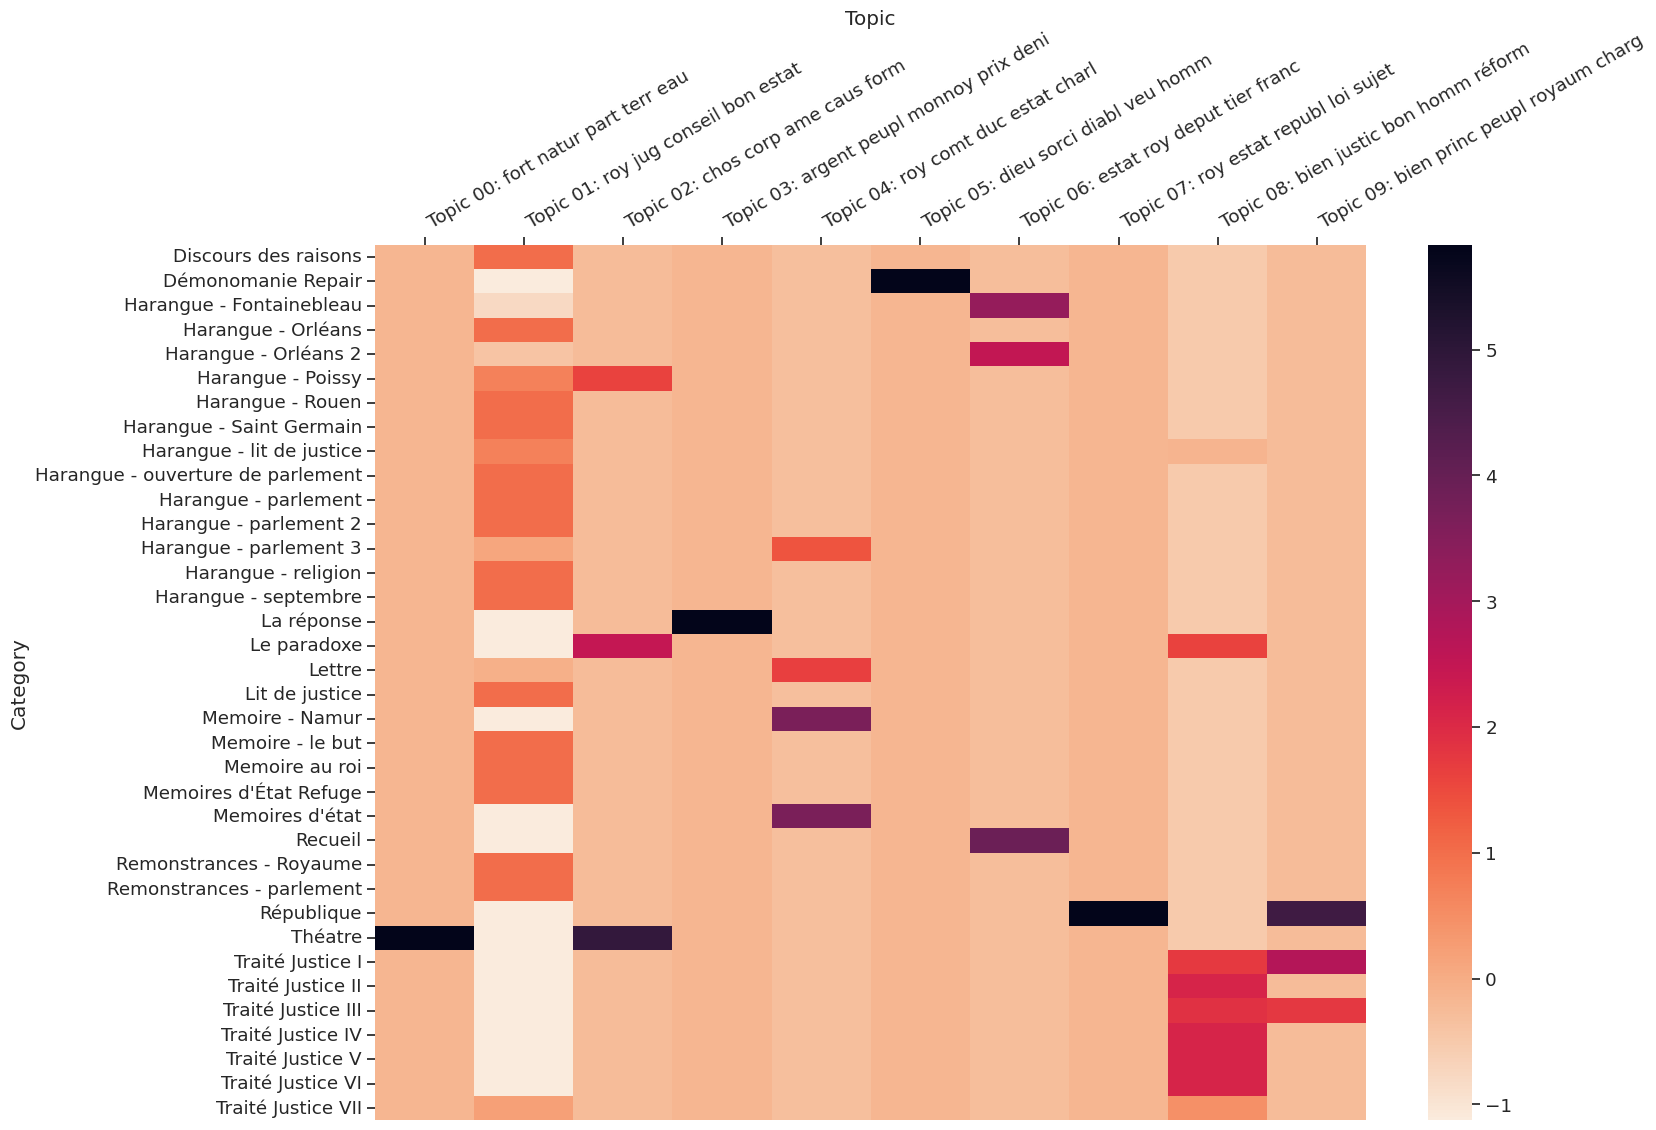

Heatmap saved: /workspaces/Jerusalimiec-Dissertation/Text/Collected/lemmatized/Sept0225b/topics_10/categories_by_topics.pdf


In [6]:
import os
from pathlib import Path
import matplotlib.pyplot as plt
import little_mallet_wrapper

# Defaults for plot dimensions and output
DEFAULT_DPI = 300
DEFAULT_DIM_INCHES = (13, 9)  # (width in inches, height in inches)
OUTPUT_DIR = None  # Will be set by user input
NUM_TOPICS = None  # Will be set by user input

# Helper to normalize labels by removing unwanted suffix patterns
# Applies to any filename-derived label used in charts.
REMOVALS = ["_corrected", "_stemmed"]

# Map simple ASCII variants to accented forms we want in labels
REPLACEMENTS = {"Traite": "Traité"}

def _clean_label(name: str) -> str:
    base = Path(name).stem
    for pat in REMOVALS:
        base = base.replace(pat, "")
    # Apply desired replacements (e.g., add accents)
    for src, dst in REPLACEMENTS.items():
        base = base.replace(src, dst)
    return base

# Helper function to load model results from the output directory
# Loads topic keys, document-topic distributions, and filenames used in modeling
# Returns: (list of filenames, list of topics, list of doc-topic distributions)
def _load_model_results():
    """
    Load topic keys, distributions, and filenames from the last pipeline run.
    """
    if not OUTPUT_DIR or not NUM_TOPICS:
        raise RuntimeError(
            "OUTPUT_DIR and NUM_TOPICS must be set at module level. "
            "Define them before calling plotting functions."
        )

    key_file = os.path.join(OUTPUT_DIR, f"mallet.topic_keys.{NUM_TOPICS}")
    dist_file = os.path.join(OUTPUT_DIR, f"mallet.topic_distributions.{NUM_TOPICS}")
    topics = little_mallet_wrapper.load_topic_keys(key_file)
    doc_topics = little_mallet_wrapper.load_topic_distributions(dist_file)

    fn_list = os.path.join(OUTPUT_DIR, "input_filenames.txt")
    with open(fn_list, "r", encoding="utf-8") as f:
        files = [line.strip() for line in f]

    return files, topics, doc_topics

# Generate and save a heatmap of topic-by-document probabilities
# Prompts user for width, calculates figure size, and saves as PDF
# Uses little_mallet_wrapper's plotting function
# Only works if OUTPUT_DIR and NUM_TOPICS are set and model results exist
def generate_heatmap():
    """
    Prompt for a desired chart width in pixels, then generate and save a
    topic-by-document heatmap. Exports only PDF + PNG.
    """
    try:
        width_px = int(input("Enter heatmap width in pixels (e.g. 1600): ").strip())
    except ValueError:
        width_px = int(DEFAULT_DIM_INCHES[0] * DEFAULT_DPI)
        print(f"Invalid input, defaulting to {width_px} px width ({DEFAULT_DPI} DPI).")

    dpi_value = DEFAULT_DPI
    aspect = DEFAULT_DIM_INCHES[1] / DEFAULT_DIM_INCHES[0]
    height_px = int(width_px * aspect)
    figsize = (width_px / dpi_value, height_px / dpi_value)

    print(f"[Heatmap] width_px={width_px}, height_px={height_px}, dpi={dpi_value}")

    files, topics, doc_topics = _load_model_results()
    labels = [_clean_label(fn) for fn in files]

    plt.close('all')
    pdf_out = os.path.join(OUTPUT_DIR, "categories_by_topics.pdf")
    fig = little_mallet_wrapper.plot_categories_by_topics_heatmap(
        labels,
        doc_topics,
        topics,
        pdf_out,
        target_labels=labels,
        dim=figsize
    )

    if fig is None:
        fig = plt.gcf()

    fig.canvas.draw()
    plt.close(fig)

    print(f"Heatmap saved: {pdf_out}")

# Generate and save a grid of boxplots (one subplot per topic)
# Prompts user for width, calculates figure size, and saves as JPG
# Each subplot shows the distribution of topic probabilities across documents
def generate_boxplot_grid():
    """
    Prompt for a desired chart width in pixels, then draw a grid of boxplots
    (one subplot per topic) and save as a single PDF + PNG.
    """
    try:
        width_px = int(input("Enter boxplot-grid width in pixels (e.g. 1600): ").strip())
    except ValueError:
        width_px = int(DEFAULT_DIM_INCHES[0] * DEFAULT_DPI)
        print(f"Invalid input, defaulting to {width_px} px width ({DEFAULT_DPI} DPI).")

    dpi_value = DEFAULT_DPI
    aspect = DEFAULT_DIM_INCHES[1] / DEFAULT_DIM_INCHES[0]
    height_px = int(width_px * aspect)
    figsize = (width_px / dpi_value, height_px / dpi_value)

    print(f"[Boxplot grid] width_px={width_px}, height_px={height_px}, dpi={dpi_value}")

    files, topics, doc_topics = _load_model_results()
    labels = [_clean_label(fn) for fn in files]
    n_topics = len(topics)

    cols = 2
    rows = (n_topics + cols - 1) // cols

    plt.close('all')
    fig, axes = plt.subplots(rows, cols,
                             figsize=figsize,
                             dpi=dpi_value,
                             sharex=True)
    axes = axes.flatten()

    for t_idx in range(n_topics):
        ax = axes[t_idx]
        data = [doc_topics[i][t_idx] for i in range(len(doc_topics))]
        ax.boxplot(data, vert=False)
        ax.set_title(f"Topic {t_idx}")
        ax.set_yticks([])

    for ax in axes[n_topics:]:
        ax.axis("off")

    fig.tight_layout()

    png_path = os.path.join(OUTPUT_DIR, "all_topic_boxplots.jpg")
    fig.savefig(png_path, dpi=dpi_value)
    plt.close(fig)

    print(f"Boxplot grid saved: {png_path}")

# Generate and save one boxplot per topic using little_mallet_wrapper's function
# Prompts user for width, calculates figure size, and saves each as a PDF
# Each plot shows the distribution of a single topic across all documents
def generate_lmw_boxplots():
    """
    Prompt for a desired chart width in pixels, then generate and save
    boxplots for each topic using lmw's plot_categories_by_topic_boxplots.
    """
    try:
        width_px = int(input("Enter LMW boxplot width in pixels (e.g. 1600): ").strip())
    except ValueError:
        width_px = int(DEFAULT_DIM_INCHES[0] * DEFAULT_DPI)
        print(f"Invalid input, defaulting to {width_px} px width ({DEFAULT_DPI} DPI).")

    dpi_value = DEFAULT_DPI
    aspect = DEFAULT_DIM_INCHES[1] / DEFAULT_DIM_INCHES[0]
    height_px = int(width_px * aspect)
    figsize = (width_px / dpi_value, height_px / dpi_value)

    print(f"[LMW per-topic PDFs] width_px={width_px}, height_px={height_px}, dpi={dpi_value}")

    files, topics, doc_topics = _load_model_results()
    labels = [_clean_label(fn) for fn in files]
    n_topics = len(topics)

    plt.close('all')
    out_paths = []
    for topic_idx in range(n_topics):
        out_path = os.path.join(
            OUTPUT_DIR, f"lmw_topic_boxplots_topic_{topic_idx}.pdf"
        )
        fig = little_mallet_wrapper.plot_categories_by_topic_boxplots(
            labels,
            doc_topics,
            topics,
            topic_idx,  # <--- This is the missing argument!
            output_path=out_path,
            target_labels=None,
            dim=figsize
        )
        if fig is None:
            fig = plt.gcf()
        fig.canvas.draw()
        plt.close(fig)
        out_paths.append(out_path)

    print(f"LMW boxplots saved: {', '.join(out_paths)}")
    
# Main entry point for plotting: prompts user for output folder, number of topics, and which plots to generate
def main():
    global OUTPUT_DIR, NUM_TOPICS

    # --- MODIFIED ---
    # Helper to find all possible run directories by searching for key files.
    def find_run_dirs(root='.'):
        run_dirs = []
        for r, _, files in os.walk(root):
            if any(f.startswith("mallet.topic_keys.") for f in files):
                run_dirs.append(r)
        return run_dirs

    # Let user choose from available run directories
    print("Searching for topic model run directories...")
    possible_dirs = find_run_dirs(os.getcwd())

    if not possible_dirs:
        print("No topic model run directories found in this folder or its subfolders.")
        return

    print("Please select a run directory:")
    for i, d in enumerate(possible_dirs, 1):
        print(f"[{i}] {os.path.relpath(d)}")

    choice = -1
    while not (1 <= choice <= len(possible_dirs)):
        try:
            choice = int(input(f"Enter number (1-{len(possible_dirs)}): ").strip())
        except ValueError:
            print("Invalid input.")

    OUTPUT_DIR = possible_dirs[choice - 1]

    # Infer number of topics from the chosen directory's files
    try:
        topic_keys_file = next(f for f in os.listdir(OUTPUT_DIR) if f.startswith("mallet.topic_keys."))
        NUM_TOPICS = int(topic_keys_file.split('.')[-1])
        print(f"Successfully loaded run directory '{os.path.relpath(OUTPUT_DIR)}' with {NUM_TOPICS} topics.")
    except (StopIteration, ValueError):
        print("Could not automatically determine the number of topics from the files.")
        num_topics_str = input("Please enter the number of topics manually: ").strip()
        NUM_TOPICS = int(num_topics_str)
    # --- END MODIFIED ---

    # Prompt user to select which plots to generate
    print("\nSelect which plots to generate:")
    print("1) Heatmap (PDF)")
    print("2) Boxplot grid (JPG)")
    print("3) LMW boxplots (PDF, label-based)")
    print("Type any combination of these numbers separated by commas (e.g. 1,2,3), or 'all' for all:")
    choice = input("Your choice: ").lower()

    if "all" in choice:
        generate_heatmap()
        generate_boxplot_grid()
        generate_lmw_boxplots()
    else:
        if '1' in choice:
            generate_heatmap()
        if '2' in choice:
            generate_boxplot_grid()
        if '3' in choice:
            generate_lmw_boxplots()

if __name__ == "__main__":
    main()

In [ ]:
import os
from pathlib import Path

# Prompt the user to select a MALLET run folder (must contain 'input_filenames.txt').
# Searches recursively from the current working directory to find valid runs.
def choose_mallet_run(root=".", prompt="Select a MALLET run folder (contains 'input_filenames.txt'):"):
    """
    Recursively search from 'root' for folders that contain 'input_filenames.txt'.
    Returns the full path to the selected folder, or None if none found.
    Also shows which topic distributions are available in each folder.
    """
    run_candidates = []  # list of tuples: (abs_path, [topic_counts])
    for r, dirs, files in os.walk(root):
        # Skip checkpoint folders
        if ".ipynb_checkpoints" in r.split(os.sep):
            continue
        if "input_filenames.txt" in files:
            # Collect available topic counts in this run folder, if any
            topics_here = []
            for f in files:
                if f.startswith("mallet.topic_distributions."):
                    try:
                        topics_here.append(int(f.split(".")[-1]))
                    except ValueError:
                        pass
            topics_here = sorted(set(topics_here))
            run_candidates.append((r, topics_here))

    if not run_candidates:
        print("No MALLET run folders found under this directory.")
        print("Tip: select a 'topics_{N}' folder created by the training pipeline, or re-run the pipeline to generate results.")
        return None

    print(prompt)
    for i, (path, topics) in enumerate(run_candidates, start=1):
        rel = os.path.relpath(path, os.getcwd())
        suffix = f" (topics: {', '.join(map(str, topics))})" if topics else ""
        print(f"[{i}] {rel}{suffix}")

    while True:
        try:
            choice = int(input("Enter number: ").strip())
            if 1 <= choice <= len(run_candidates):
                return run_candidates[choice - 1][0]
        except ValueError:
            pass
        print("Invalid choice, please try again.")

# Load the list of filenames (in modeling order) and the topic distributions
# for a given MALLET run and number of topics.
def load_model_data(run_dir, num_topics):
    """
    Load the file list (input_filenames.txt) and the doc-topic distributions
    for the specified number of topics from 'run_dir'.
    Ensures that the order of files matches how they were used in modeling.
    """
    fn_list_path = os.path.join(run_dir, "input_filenames.txt")
    if not os.path.exists(fn_list_path):
        raise FileNotFoundError(f"'input_filenames.txt' not found in {run_dir}.")

    # Read the filenames in the order used for modeling
    with open(fn_list_path, "r", encoding="utf-8") as f:
        files = [line.strip() for line in f]

    dist_file = os.path.join(run_dir, f"mallet.topic_distributions.{num_topics}")
    if not os.path.exists(dist_file):
        raise FileNotFoundError(f"No doc-topic distribution file for {num_topics} topics in {run_dir}.")

    import little_mallet_wrapper
    # Load the topic distributions for each file
    doc_topics = little_mallet_wrapper.load_topic_distributions(dist_file)
    return files, doc_topics

# Prompt the user to select files by index, range, or 'all'.
# Returns a sorted list of selected indices (0-based).
def select_indices_in_files(file_list, group_name):
    """
    Prompt the user to pick files by:
      - 'all'
      - single indices (e.g. '3')
      - index ranges (e.g. '2-5')
      or any combination separated by commas (e.g. '1,2-4,7').

    Returns a sorted list of chosen indices (0-based).
    """
    print(f"\nSelect indices for {group_name}. Possible choices:")
    for i, f in enumerate(file_list, start=1):
        print(f"[{i}] {f}")
    user_input = input(
        f"Enter comma-separated indices or ranges, or 'all' for {group_name}: "
    ).strip().lower()

    if user_input == "all":
        return list(range(len(file_list)))

    chosen = []
    for part in user_input.split(","):
        part = part.strip()
        if "-" in part:
            # Handle range syntax "start-end"
            try:
                start_str, end_str = part.split("-")
                start = int(start_str.strip())
                end = int(end_str.strip())
                if start <= end:
                    chosen.extend(range(start - 1, end))
                else:
                    # If user reversed them accidentally, handle gracefully:
                    chosen.extend(range(end - 1, start))
            except ValueError:
                print(f"Ignoring invalid range: '{part}'")
        else:
            # Handle single numeric index
            try:
                idx = int(part) - 1
                chosen.append(idx)
            except ValueError:
                print(f"Ignoring invalid entry: '{part}'")

    # Remove duplicates and ensure ascending order
    final_indices = sorted(set(i for i in chosen if 0 <= i < len(file_list)))
    return final_indices

# Compute the average topic distance (L1 norm) between two topic distributions.
def average_topic_distance(dist_a, dist_b):
    """
    Calculate the average distance between two topic distributions
    by summing absolute differences and dividing by the number of topics.
    """
    return sum(abs(a - b) for a, b in zip(dist_a, dist_b)) / len(dist_a)

# Main logic for comparing two groups of files:
# 1. Prompt user to select Group 1 files.
# 2. Automatically assign Group 2 as all remaining files.
# 3. Prompt user to select one or more TARGET files from Group 1 (indices or ranges).
# 4. For each selected target, compare to all files in Group 2 and rank by similarity.
def compare_two_groups(files, doc_topics):
    """
    1) Select Group 1 indices from 'files'.
    2) Auto-assign Group 2 as the complement of Group 1.
    3) Select one or more TARGET files from Group 1 (single indices, ranges, or 'all').
    4) For each target, compare to every file in Group 2 and rank by average topic distance.
    """
    # 1) Pick Group 1
    group1_indices = select_indices_in_files(files, "Group 1")
    if not group1_indices:
        print("No files selected for Group 1; aborting.")
        return

    # 2) Auto-assign Group 2 as complement
    total_indices = set(range(len(files)))
    group1_set = set(group1_indices)
    group2_indices = sorted(total_indices - group1_set)
    if not group2_indices:
        print("Group 2 would be empty (Group 1 contains all files). Please select fewer files for Group 1.")
        return

    print(f"\nGroup 1: {len(group1_indices)} file(s)")
    for i in group1_indices:
        print(f"  - {files[i]}")
    print(f"\nGroup 2 (auto-selected complement): {len(group2_indices)} file(s)")
    for i in group2_indices:
        print(f"  - {files[i]}")

    # 3) Pick one or more TARGET files from within Group 1
    print("\nSelect target file(s) FROM the previously chosen Group 1.")
    group1_files = [files[i] for i in group1_indices]
    target_rel = select_indices_in_files(group1_files, "Targets in Group 1")
    if not target_rel:
        print("No targets selected; aborting.")
        return
    target_indices = [group1_indices[i] for i in target_rel]

    # 4) For each target, compute metrics against every file in Group 2
    for t_pos, target_idx in enumerate(target_indices, start=1):
        target_name = files[target_idx]
        target_dist = doc_topics[target_idx]
        K = len(target_dist)
        theoretical_max_avg = 2.0 / K  # when two distributions are disjoint point masses

        print("\n" + "=" * 80)
        print(f"Target {t_pos}/{len(target_indices)}: {target_name}")
        print("-" * 80)
        print(f"Per-topic metrics across K={K} topics (theoretical max avg distance = 2/K = {theoretical_max_avg:.4f})")

        distances = []
        for idx in group2_indices:
            other_dist = doc_topics[idx]
            # L1 sum over topics
            l1_sum = sum(abs(a - b) for a, b in zip(target_dist, other_dist))
            avg = l1_sum / K
            tv = 0.5 * l1_sum
            similarity = 1.0 - tv
            distances.append((files[idx], avg, l1_sum, tv, similarity))

        # Sort by ascending average distance (most similar first)
        distances.sort(key=lambda x: x[1])

        print("Top 10 by similarity (ascending avg distance):")
        for rank, (fname, avg, l1_sum, tv, similarity) in enumerate(distances[:10], start=1):
            print(
                f"{rank}. {fname} "
                f"(avg={avg:.4f}, L1={l1_sum:.4f}, TV={tv:.4f}, similarity={similarity:.4f})"
            )

# Helper to infer available topic counts in the selected run folder, or prompt the user
# if multiple or none are found.
def infer_or_prompt_num_topics(run_dir):
    files = os.listdir(run_dir)
    candidates = []
    for f in files:
        if f.startswith("mallet.topic_distributions."):
            try:
                candidates.append(int(f.split(".")[-1]))
            except ValueError:
                pass
    candidates = sorted(set(candidates))

    if not candidates:
        # Fall back to manual entry
        return int(input("Enter the number of topics used for that run: ").strip())

    if len(candidates) == 1:
        print(f"Detected {candidates[0]} topics in the selected run.")
        return candidates[0]

    print("Multiple topic distributions found in this run; choose one:")
    for i, n in enumerate(candidates, start=1):
        print(f"[{i}] {n}")
    while True:
        try:
            sel = int(input("Enter number: ").strip())
            if 1 <= sel <= len(candidates):
                return candidates[sel - 1]
        except ValueError:
            pass
        print("Invalid choice, please try again.")

# Entry point for the comparison workflow:
# 1. Search for a valid run folder (contains input_filenames.txt) and select it.
# 2. Infer or prompt for the number of topics available in that folder.
# 3. Load the files and topic distributions.
# 4. Launch the two-group comparison.
def start_comparison():
    """
    Guide the user to pick a valid MALLET run folder (recursively),
    infer/choose the number of topics in that folder, then compare two groups.
    """
    run_dir = choose_mallet_run(os.getcwd())
    if not run_dir:
        return
    num_topics = infer_or_prompt_num_topics(run_dir)
    files, doc_topics = load_model_data(run_dir, num_topics)
    compare_two_groups(files, doc_topics)

# Run the comparison workflow when this cell is executed
start_comparison()

Select a MALLET run folder (contains 'input_filenames.txt'):
[1] Sept0725/topics_13 (topics: 13)
[2] Sept0725/topics_14 (topics: 14)
[3] Sept0725/topics_8 (topics: 8)
[4] Sept0725/topics_12 (topics: 12)
[5] Sept0725/topics_10 (topics: 10)
[6] Sept0725/topics_11 (topics: 11)
[7] Sept0725/topics_16 (topics: 16)
[8] Sept0725/topics_9 (topics: 9)
[9] Sept0725/topics_15 (topics: 15)
[10] Sept0325/topics_13 (topics: 13)
[11] Sept0325/topics_14 (topics: 14)
[12] Sept0325/topics_8 (topics: 8)
[13] Sept0325/topics_12 (topics: 12)
[14] Sept0325/topics_10 (topics: 10)
[15] Sept0325/topics_11 (topics: 11)
[16] Sept0325/topics_16 (topics: 16)
[17] Sept0325/topics_9 (topics: 9)
[18] Sept0325/topics_15 (topics: 15)


Detected 12 topics in the selected run.

Select indices for Group 1. Possible choices:
[1] 0Théatre summary_corrected_stemmed.txt
[2] Discours des raisons_corrected_stemmed.txt
[3] Démonomanie I.1_corrected_stemmed.txt
[4] Démonomanie I.2_corrected_stemmed.txt
[5] Démonomanie I.3_corrected_stemmed.txt
[6] Démonomanie I.4_corrected_stemmed.txt
[7] Démonomanie I.5_corrected_stemmed.txt
[8] Démonomanie I.6_corrected_stemmed.txt
[9] Démonomanie I.7_corrected_stemmed.txt
[10] Démonomanie II.1_corrected_stemmed.txt
[11] Démonomanie II.2_corrected_stemmed.txt
[12] Démonomanie II.3_corrected_stemmed.txt
[13] Démonomanie II.4_corrected_stemmed.txt
[14] Démonomanie II.5_corrected_stemmed.txt
[15] Démonomanie II.6_corrected_stemmed.txt
[16] Démonomanie II.7_corrected_stemmed.txt
[17] Démonomanie II.8_corrected_stemmed.txt
[18] Démonomanie III.1_corrected_stemmed.txt
[19] Démonomanie III.2_corrected_stemmed.txt
[20] Démonomanie III.3_corrected_stemmed.txt
[21] Démonomanie III.4_corrected_stemmed.t

## Extract standardized global topic proportions

This helper computes global topic proportions from a selected MALLET run in two ways:
- Doc-weighted (unweighted average across documents): “typical document’s topic mix.” Sums to 1.
- Token-weighted (weighted by each document’s filtered token count actually sent to MALLET): closely matches MALLET’s corpus-level topic proportions (fraction of all modeled tokens assigned to each topic). Recommended for MALLET-style diagnostics.

Notes:
- The `.keys` file lists top words per topic (and sometimes weights) but is truncated; those numbers aren’t meant to sum to 1 across the whole vocabulary. Use the doc–topic distributions instead.
- Token counts are read from the `preprocessed_docs.pkl` created by this notebook’s training pipeline (stored in the parent folder of the selected `topics_{K}` run). If that file is missing or its file list doesn’t match the run’s `input_filenames.txt`, the script will fall back to the doc-weighted proportions only.
- The script saves a CSV into the run directory and prints the top topics for quick inspection.

In [1]:
import os
from pathlib import Path
import numpy as np
import pandas as pd


# Prompt the user to select a MALLET run folder (must contain 'input_filenames.txt').
# Searches recursively from the current working directory to find valid runs.
def choose_mallet_run(root=".", prompt="Select a MALLET run folder (contains 'input_filenames.txt'):"):
    """
    Recursively search from 'root' for folders that contain 'input_filenames.txt'.
    Returns the full path to the selected folder, or None if none found.
    Also shows which topic distributions are available in each folder.
    """
    run_candidates = []  # list of tuples: (abs_path, [topic_counts])
    for r, dirs, files in os.walk(root):
        # Skip checkpoint folders
        if ".ipynb_checkpoints" in r.split(os.sep):
            continue
        if "input_filenames.txt" in files:
            # Collect available topic counts in this run folder, if any
            topics_here = []
            for f in files:
                if f.startswith("mallet.topic_distributions."):
                    try:
                        topics_here.append(int(f.split(".")[-1]))
                    except ValueError:
                        pass
            topics_here = sorted(set(topics_here))
            run_candidates.append((r, topics_here))

    if not run_candidates:
        print("No MALLET run folders found under this directory.")
        print("Tip: select a 'topics_{N}' folder created by the training pipeline, or re-run the pipeline to generate results.")
        return None

    print(prompt)
    for i, (path, topics) in enumerate(run_candidates, start=1):
        rel = os.path.relpath(path, os.getcwd())
        suffix = f" (topics: {', '.join(map(str, topics))})" if topics else ""
        print(f"[{i}] {rel}{suffix}")

    while True:
        try:
            choice = int(input("Enter number: ").strip())
            if 1 <= choice <= len(run_candidates):
                return run_candidates[choice - 1][0]
        except ValueError:
            pass
        print("Invalid choice, please try again.")

# Helper to infer available topic counts in the selected run folder, or prompt the user
# if multiple or none are found.
def infer_or_prompt_num_topics(run_dir):
    files = os.listdir(run_dir)
    candidates = []
    for f in files:
        if f.startswith("mallet.topic_distributions."):
            try:
                candidates.append(int(f.split(".")[-1]))
            except ValueError:
                pass
    candidates = sorted(set(candidates))

    if not candidates:
        # Fall back to manual entry
        return int(input("Enter the number of topics used for that run: ").strip())

    if len(candidates) == 1:
        print(f"Detected {candidates[0]} topics in the selected run.")
        return candidates[0]

    print("Multiple topic distributions found in this run; choose one:")
    for i, n in enumerate(candidates, start=1):
        print(f"[{i}] {n}")
    while True:
        try:
            sel = int(input("Enter number: ").strip())
            if 1 <= sel <= len(candidates):
                return candidates[sel - 1]
        except ValueError:
            pass
        print("Invalid choice, please try again.")

# Load the list of filenames (in modeling order) and the topic distributions
# for a given MALLET run and number of topics.
def load_model_data(run_dir, num_topics):
    """
    Load the file list (input_filenames.txt) and the doc-topic distributions
    for the specified number of topics from 'run_dir'.
    Ensures that the order of files matches how they were used in modeling.
    """
    fn_list_path = os.path.join(run_dir, "input_filenames.txt")
    if not os.path.exists(fn_list_path):
        raise FileNotFoundError(f"'input_filenames.txt' not found in {run_dir}.")

    # Read the filenames in the order used for modeling
    with open(fn_list_path, "r", encoding="utf-8") as f:
        files = [line.strip() for line in f]

    dist_file = os.path.join(run_dir, f"mallet.topic_distributions.{num_topics}")
    if not os.path.exists(dist_file):
        raise FileNotFoundError(f"No doc-topic distribution file for {num_topics} topics in {run_dir}.")

    import little_mallet_wrapper
    # Load the topic distributions for each file
    doc_topics = little_mallet_wrapper.load_topic_distributions(dist_file)
    return files, doc_topics


def _load_run_interactive():
    # Reuse the robust chooser already in this notebook
    run_dir = choose_mallet_run(os.getcwd(), prompt="Select a MALLET run for proportions:")
    if not run_dir:
        return None, None, None
    K = infer_or_prompt_num_topics(run_dir)
    files, doc_topics = load_model_data(run_dir, K)
    return run_dir, files, np.array(doc_topics, dtype=float)


def _try_load_token_counts(run_dir, files):
    """Attempt to load per-document token counts from sibling preprocessed data.
    Looks for preprocessed_docs.pkl in the parent folder of run_dir and verifies file order.
    Returns counts list (filtered-token counts used for modeling) or None if unavailable/mismatch.
    """
    import pickle
    parent = Path(run_dir).parent
    pkl_path = parent / "preprocessed_docs.pkl"
    if not pkl_path.exists():
        return None
    try:
        with open(pkl_path, "rb") as f:
            training_docs, token_distributions, target_files = pickle.load(f)
        # Ensure the exact file order matches the run
        if list(target_files) != list(files):
            print(
                "Warning: preprocessed_docs.pkl file list does not match run's input_filenames.txt; "
                "skipping token weighting."
            )
            return None
        # Use the FILTERED token counts that were actually passed to MALLET
        counts = [len(doc.split()) for doc in training_docs]
        return counts
    except Exception as e:
        print(f"Warning: could not read token counts from {pkl_path}: {e}")
        return None


def compute_global_topic_proportions():
    run_dir, files, doc_topics = _load_run_interactive()
    if run_dir is None:
        raise SystemExit
    K = doc_topics.shape[1]

    # Doc-weighted (simple mean across documents)
    doc_weighted = doc_topics.mean(axis=0)
    doc_weighted = doc_weighted / doc_weighted.sum()  # normalize for safety

    # Token-weighted (if filtered token counts available)
    counts = _try_load_token_counts(run_dir, files)
    token_weighted = None
    if counts is not None and len(counts) == doc_topics.shape[0]:
        weights = np.asarray(counts, dtype=float)
        total = weights.sum()
        if total > 0:
            weights = weights / total
            token_weighted = weights @ doc_topics  # shape: (K,)
            token_weighted = token_weighted / token_weighted.sum()
        else:
            print("Warning: zero total token count; skipping token-weighted proportions.")

    # Prepare Excel output
    data = {
        "topic_index": list(range(K)),
        "doc_weighted": doc_weighted.astype(float),
    }
    if token_weighted is not None:
        data["token_weighted"] = token_weighted.astype(float)

    df = pd.DataFrame(data)
    out_xlsx = os.path.join(run_dir, "global_topic_proportions.xlsx")
    df.to_excel(out_xlsx, index=False)

    # Print quick diagnostics
    print(f"Saved global proportions to: {out_xlsx}")
    print("Doc-weighted top 5 topics:")
    for t in np.argsort(-doc_weighted)[:5]:
        print(f"  Topic {t}: {doc_weighted[t]:.4f}")
    if token_weighted is not None:
        print("Token-weighted top 5 topics:")
        for t in np.argsort(-token_weighted)[:5]:
            print(f"  Topic {t}: {token_weighted[t]:.4f}")


# Run it
compute_global_topic_proportions()

Select a MALLET run for proportions:
[1] Sept0225/topics_13 (topics: 13)
[2] Sept0225/topics_14 (topics: 14)
[3] Sept0225/topics_8 (topics: 8)
[4] Sept0225/topics_12 (topics: 12)
[5] Sept0225/topics_10 (topics: 10)
[6] Sept0225/topics_11 (topics: 11)
[7] Sept0225/topics_16 (topics: 16)
[8] Sept0225/topics_9 (topics: 9)
[9] Sept0225/topics_15 (topics: 15)
[10] Sept0225b/topics_13 (topics: 13)
[11] Sept0225b/topics_14 (topics: 14)
[12] Sept0225b/topics_8 (topics: 8)
[13] Sept0225b/topics_12 (topics: 12)
[14] Sept0225b/topics_10 (topics: 10)
[15] Sept0225b/topics_11 (topics: 11)
[16] Sept0225b/topics_16 (topics: 16)
[17] Sept0225b/topics_9 (topics: 9)
[18] Sept0225b/topics_15 (topics: 15)
Detected 10 topics in the selected run.
Saved global proportions to: /workspaces/Jerusalimiec-Dissertation/Text/Collected/lemmatized/Sept0225b/topics_10/global_topic_proportions.xlsx
Doc-weighted top 5 topics:
  Topic 1: 0.5254
  Topic 8: 0.1965
  Topic 4: 0.0810
  Topic 6: 0.0696
  Topic 5: 0.0278
Token